- Construir una matriz INPUTS 150 x 4
- Crear una matriz OUTPUT 150 x 1
- Crear variable numEjemplos (size) (150)
- Crear variable numClases (unique(OUTPUT)) (3)
- Guardar las 4 variables 'iris'

In [29]:
import pandas as pd
import os
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle

In [2]:
# Cargamos dataset iris
iris = pd.read_csv('iris.data', header=None, names=['largo_sepalo','ancho_sepalo','largo_petalo','ancho_petalo','clase'])

In [3]:
y = iris.clase.values
X = iris.drop('clase',axis=1).values

In [4]:
bcw = pd.read_csv('./breast-cancer-wisconsin.data', header=None)

In [5]:
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)

In [6]:
y_pred = clf.fit_predict(X)

In [7]:
X_scores = clf.negative_outlier_factor_

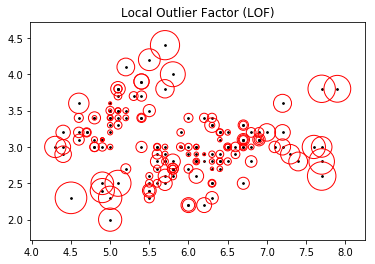

In [8]:
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(X[:, 0], X[:, 1], s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.show()

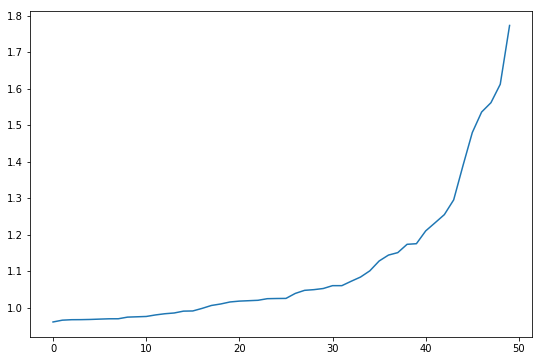

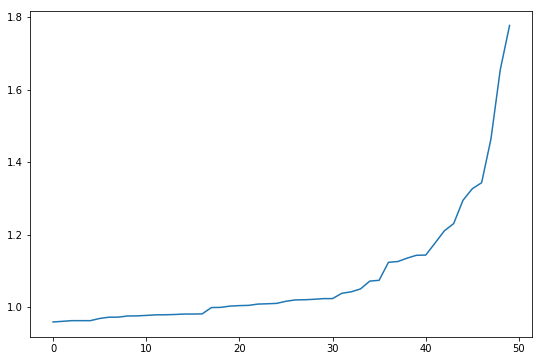

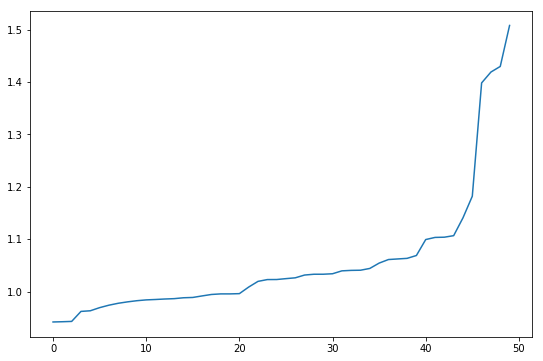

In [9]:
for i in set(y):
    # Create a figure instance
    fig = plt.figure(figsize=(9, 6))

    # Create an axes instance
    ax = fig.add_subplot(111)
    temp = X[y == i]
    y_pred = clf.fit_predict(temp)
    temp_scores = clf.negative_outlier_factor_
    ax.plot(range(len(temp_scores)),sorted(-temp_scores))

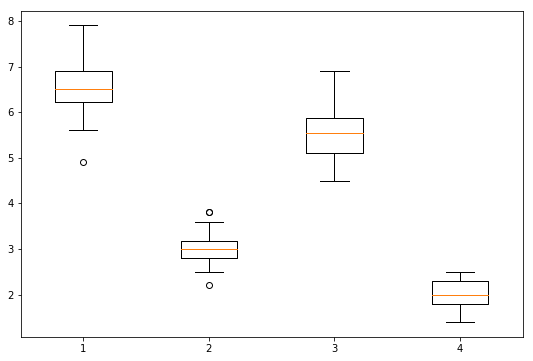

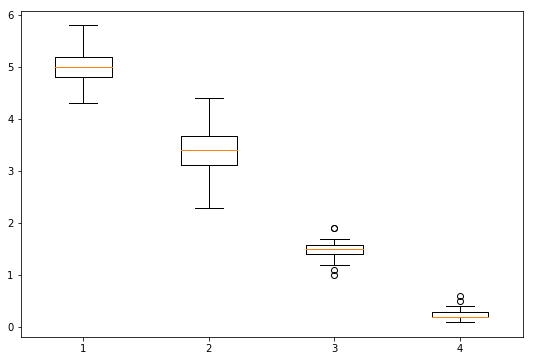

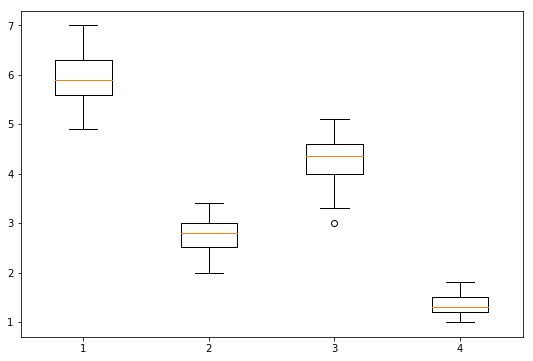

In [10]:
# X[y == 'Iris-versicolor']
for i in set(y):
    # Create a figure instance
    fig = plt.figure(figsize=(9, 6))

    # Create an axes instance
    ax = fig.add_subplot(111)
    temp = X[y == i]
    data = []
    for j in range(X.shape[1]):
        data.append(temp[:,j])
    bp = ax.boxplot(data)
#         print(temp[:,j])
plt.show()

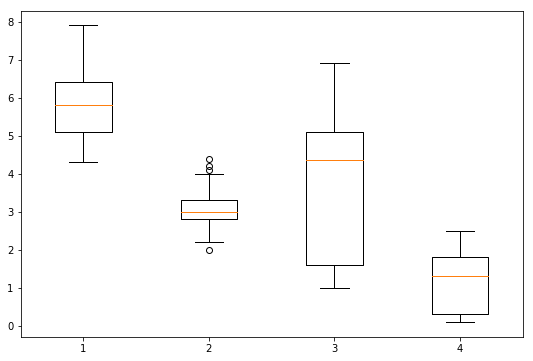

In [11]:
# Create a figure instance
fig = plt.figure(figsize=(9, 6))
# Create an axes instance
ax = fig.add_subplot(111)
data = []
for j in range(X.shape[1]):
    data.append(X[:,j])
bp = ax.boxplot(data)
plt.show()

## Preprocesado de datos

**Comprobamos que no haya "missing values"**  
Dado que no los hay, seguimos adelante.

In [12]:
attr = []
# Iteramos los atributos del dataset
for i in iris.columns:
    # Comprobamos los valores de cada atributo
    attr.append(np.all(iris[i].notna()))
# Ningún atributo tiene missing values:
np.all(np.array(attr))

True

**Comprobamos que no haya variables con "near-zero variance"**  
Vemos que no hay ninguna.

In [13]:
iris.columns.drop('clase')[iris.std() < 0.001]

Index([], dtype='object')

**Comprobamos que no haya variables iguales**  
Vemos que no hay ninguna.

In [14]:
resultados = np.zeros((len(iris.columns), len(iris.columns)))
for i in range(len(iris.columns)):
    for j in range(len(iris.columns)):
        resultados[i, j] = np.mean(iris.iloc[:, i] == iris.iloc[:, j])

In [15]:
iguales = []
for i, j in it.combinations(range(len(iris.columns)), 2):
    if round(resultados[i, j], 4) == 1:
        iguales.append(iris.columns[i])
        print(iris.columns[i], iris.columns[j])

**Comprobamos que las clases no estén desbalanceadas**  


In [16]:
y = np.array([i for i,j in enumerate(set(y)) for k in y if j == k])

In [17]:
print('Proporción clase 0: ',np.mean(y==0))
print('Proporción clase 1: ',np.mean(y==1))
print('Proporción clase 2: ',np.mean(y==2))

Proporción clase 0:  0.3333333333333333
Proporción clase 1:  0.3333333333333333
Proporción clase 2:  0.3333333333333333


## Entrenamiento de Modelos

**Hold Out**

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [19]:
alg = LinearDiscriminantAnalysis(solver='eigen', shrinkage=None)
alg.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='eigen', store_covariance=False, tol=0.0001)

In [20]:
y_pred = alg.predict(X_test)
# Accuracy y Conf. Matrix:
print('Accuracy: ',alg.score(X_test, y_test))
print(confusion_matrix(y_test, y_pred))

Accuracy:  0.9666666666666667
[[12  0  0]
 [ 0  9  0]
 [ 0  1  8]]


**GridSearch**

In [24]:
shrinkage = [None, 'auto']
shrinkage.extend(np.round(np.linspace(0.1, 0.9, 8), 1))
param_grid = {'solver': ('lsqr', 'eigen'), 'shrinkage': shrinkage}
grid = GridSearchCV(alg, param_grid=param_grid, cv=10, return_train_score=True)
X,y = shuffle(X,y)
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_score_)

{'shrinkage': None, 'solver': 'lsqr'}
0.98


In [ ]:
# print(classification_report(y_true, y_pred, target_names=target_names))

In [30]:
kf = KFold(n_splits=10)
resultados_train = []
resultados_test = []
for tipo in ('lsqr', 'eigen', 'svd'):
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        alg = LinearDiscriminantAnalysis(solver=tipo, shrinkage=None)
        alg.fit(X_train, y_train)
        # print(classification_report(y_true, y_pred, target_names=target_names))
        resultados_train.append(alg.score(X_train, y_train))
        resultados_test.append(alg.score(X_test, y_test))

In [26]:
from scipy import stats
# stats.kruskal(x, y)

In [25]:
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
# MultiComp = MultiComparison(stacked_data['result'],
#                             stacked_data['treatment'])
# print(MultiComp.tukeyhsd().summary())


**----------------------------------------------------------------------------------------------------------------------------**

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     ParameterGrid, cross_val_score,
                                    learning_curve, ShuffleSplit)
from imblearn.over_sampling import SMOTE
import warnings
import itertools as it
import pickle
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
# Cargamos dataset
df = pd.read_csv(os.path.join('ds_Zika.csv'))

In [7]:
# Eliminamos esas columnas
df = df.drop(columns=[df.columns[5],df.columns[9]])
resultados = np.delete(resultados, [5,9], axis=0)
resultados = np.delete(resultados, [5,9], axis=1)

In [9]:
# Eliminamos esas columnas
df = df.drop(columns=list(set(iguales)))

**Undersampling**  
Reducimos el número de muestras negativas al número de muestras positivas, seleccionandolas de forma aleatoria.

In [11]:
df_u = df.copy()
# Número de casos positivos
nposit = len(df_u[df_u['Output'] == 1])
# Índices de casos negativos
inegat = df_u[df_u.Output == 0].index
# Cogemos aleatoriamente un número de índices negativos igual al número de casos positivos
random_indices = np.random.choice(inegat, nposit, replace=False)
# Obtenemos todos los índices positivos
iposit = df_u[df_u.Output == 1].index
# Unimos las dos listas de índices
new_indices = np.concatenate([iposit, random_indices])
df_u = df_u.loc[new_indices]
# y las desordenamos
df_u = shuffle(df_u).reset_index(drop=True)

X_u = df_u.drop('Output', axis=1)
y_u = df_u['Output']

Xdata_u = X_u.values
ydata_u = y_u.values

**Oversampling**  
Se generan muestras sinteticas positivas que siguen la misma distribución que las originales.

In [12]:
df_o = df.copy()
X_o = df_o.drop('Output', axis=1)
y_o = df_o['Output']
Xdata_o = X_o.values
ydata_o = y_o.values
Xdata_o, ydata_o = SMOTE().fit_resample(Xdata_o, ydata_o)

## Entrenamiento de Modelos - Undersampled

In [13]:
# Suprimimos warnings para legibilidad (nota: no recomendamos hacer esto)
warnings.filterwarnings("ignore")

In [14]:
# Probamos con undersampling
Xdata = Xdata_u
ydata = ydata_u

### Selección del modelo  
Se prueba con una batería de diferentes modelos de clasificación, con los parámetros por defecto.

In [15]:
# K Neighbors
knb = KNeighborsClassifier()

# LDC:
ldc = LinearDiscriminantAnalysis()

# Bayesian:
gnb = GaussianNB()

# Multilayer Perceptron
mlp = MLPClassifier()

# SVM:
svm = SVC()

# Random Forest
rndf = RandomForestClassifier()

models = [knb, ldc, gnb, mlp, svm, rndf]
model_names = ['KNeighborsClassifier', 'LinearDiscriminantAnalysis', 'GaussianNB',
               'MLPClassifier', 'SVC', 'RandomForestClassifier']
scores = []
for model in models:
    score = cross_val_score(model, Xdata, ydata, cv=10)
    scores.append((np.mean(score), np.std(score)))
x = pd.DataFrame(np.array(scores), columns=['Mean','Standard Deviation'], index=model_names)
x
# Nos quedamos con RandomForest

,Mean,Standard Deviation
KNeighborsClassifier,0.901379,0.025319
LinearDiscriminantAnalysis,0.873247,0.015974
GaussianNB,0.791616,0.030786
MLPClassifier,0.910884,0.019924
SVC,0.791616,0.030786
RandomForestClassifier,0.925389,0.012770


### Búsqueda de hiperparámetros
- n_estimators: Número de árboles
- max_depth: Profundidad máxima del árbol
- min_samples_leaf: Número mínimo de muestras requeridas en una hoja

In [16]:
# División entre training y test
X_train, X_test, y_train, y_test = train_test_split(Xdata, ydata,
                                                    test_size=0.2,
                                                    stratify=ydata, random_state=1234)
# Hiperparámetros a probar
param_grid = {'n_estimators': range(1, 101, 10),
               'max_depth': range(1, 26, 5),
               'min_samples_leaf': range(1, 11, 5)}

alg = RandomForestClassifier(random_state=1234)
# Grid Search con cross validation
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=1234)
grid = GridSearchCV(alg, param_grid=param_grid, cv=cv, return_train_score=True)
grid.fit(X_train, y_train)
print(grid.best_params_)
print('validation accuracy:', grid.score(X_train, y_train))
print('test accuracy:', grid.score(X_test, y_test))

{'max_depth': 16, 'min_samples_leaf': 1, 'n_estimators': 71}
validation accuracy: 0.9993734335839599
test accuracy: 0.935


**Mejores parámetros**  
La función GridSearchCV devuelve unos parámetros que tienen una gran diferencia entre el train score y el test score, por lo tanto establecemos un nuevo criterio para la selección de los mismos.

In [17]:
# Queremos que haya poca diferencia entre validación y test
c = pd.DataFrame(grid.cv_results_)
c['train_test_difference'] = c.mean_train_score - c.mean_test_score
# Diferencia máxima entre validación y test
max_diff = 0.02
# Precisión mínima en test
min_test_score = 0.90
c_sorted = c[(c.mean_test_score >= min_test_score) & (c.train_test_difference <= max_diff)][(
    ['mean_train_score', 'mean_test_score','train_test_difference'])].sort_values('mean_test_score', ascending=False)
# Ordenamos por error en test
c_sorted.head(n=10)

,mean_train_score,mean_test_score,train_test_difference
36,0.925705,0.910000,0.015705
38,0.926803,0.909375,0.017428
39,0.927351,0.909375,0.017976
37,0.926254,0.909062,0.017191
34,0.926019,0.908125,0.017894
32,0.924060,0.906875,0.017185
33,0.925392,0.906875,0.018517
35,0.925784,0.906875,0.018909


In [18]:
# Obtenemos los mejores hiperparámetros según nuestro criterio
i = c_sorted.first_valid_index()
max_depth = c.param_max_depth.iloc[i]
min_samples_leaf = c.param_min_samples_leaf.iloc[i]
n_estimators = c.param_n_estimators.iloc[i]
print('Max depth: {} - Min. samples leaf: {} - Num. estimators: {}'.format(max_depth, min_samples_leaf, n_estimators))

Max depth: 6 - Min. samples leaf: 6 - Num. estimators: 61


## Resultados - Undersampled

In [19]:
# Obtenemos el modelo con los hiperparámetros elegidos
alg_u = RandomForestClassifier(random_state=1234, max_depth=max_depth,
                              min_samples_leaf=min_samples_leaf, n_estimators=n_estimators)

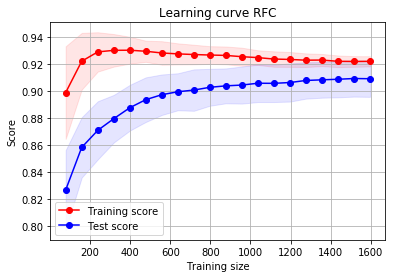

In [20]:
# Calculamos la curva de aprendizaje
cv = ShuffleSplit(n_splits=100, test_size=0.2)
train_sizes = np.linspace(0.05, 1, num=20)
train_sizes, train_scores, test_scores = learning_curve(
        alg_u, Xdata, ydata, cv=cv, train_sizes=train_sizes)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# plot
plt.figure()
plt.title('Learning curve RFC')
plt.xlabel('Training size')
plt.ylabel('Score')
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='b')
plt.plot(train_sizes, train_scores_mean, 'ro-', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'bo-', label='Test score')
plt.legend(loc='best')
plt.show()
plt.close()

In [21]:
# Cambiamos la división entre training y test
X_train, X_test, y_train, y_test = train_test_split(Xdata, ydata,
                                                    test_size=0.3,
                                                    stratify=ydata, random_state=1234)
alg_u.fit(X_train, y_train)
print('training accuracy:', alg_u.score(X_train, y_train))
print('test accuracy:', alg_u.score(X_test, y_test))
y_pred = alg_u.predict(X_test)
print(confusion_matrix(y_test, y_pred))

training accuracy: 0.9205440229062276
test accuracy: 0.9081803005008348
[[286  13]
 [ 42 258]]


**Mejores parámetros en función de la precisión en test**

In [22]:
# Modelo con mejores resultados
max_depth = grid.best_params_['max_depth']
min_samples_leaf = grid.best_params_['min_samples_leaf']
n_estimators = grid.best_params_['n_estimators']
best = RandomForestClassifier(random_state=1234, max_depth=max_depth,
                              min_samples_leaf=min_samples_leaf, n_estimators=n_estimators)

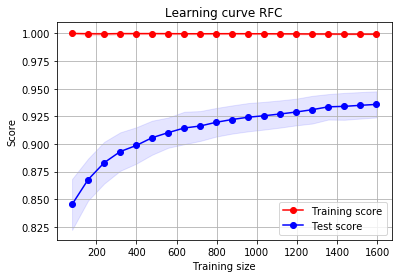

In [23]:
# Calculamos la curva de aprendizaje
cv = ShuffleSplit(n_splits=100, test_size=0.2)
train_sizes = np.linspace(0.05, 1, num=20)
train_sizes, train_scores, test_scores = learning_curve(
        best, Xdata, ydata, cv=cv, train_sizes=train_sizes)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# plot
plt.figure()
plt.title('Learning curve RFC')
plt.xlabel('Training size')
plt.ylabel('Score')
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='b')
plt.plot(train_sizes, train_scores_mean, 'ro-', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'bo-', label='Test score')
plt.legend(loc='best')
plt.show()
plt.close()

In [34]:
# Reactivamos warnings
warnings.filterwarnings("default")

## Persistencia

In [35]:
with open('RForest_Zika_oversampled.bin','wb') as file:
    pickle.dump(alg_o, file)
with open('RForest_Zika_undersampled.bin','wb') as file:
    pickle.dump(alg_u, file)

## FIN